In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import pickle

In [ ]:
# Load the train dataset
df = pd.read_csv("train.csv")

In [ ]:
df.drop(columns=["ID","date"],inplace=True)

In [ ]:
def lower_case_columns(df, cols):
    df[cols] = df[cols].astype(str).apply(lambda x: x.str.lower())
    return df
df = lower_case_columns(df, ["waste_category"])
display(df["waste_category"].value_counts())
df["staff_experience"] = df["staff_experience"].replace("intermediate", "Intermediate")


,count
waste_category,
meat,379
dairy,180
vegetables,176
grains,176


In [ ]:
cols=["special_event","staff_experience","waste_category"]
df[cols]=df[cols].astype("category")

In [ ]:
def handle_outlier(data,columns,method="IQR",threshold=1.5,strategy="replace"):
    for col in columns:
        if method=="IQR":
            Q1=data[col].quantile(0.25)
            Q3=data[col].quantile(0.75)
            IQR=Q3-Q1
            lower_bound=Q1-threshold*IQR
            upper_bound=Q3+threshold*IQR
        elif method=="Z-score":
            mean=data[col].mean()
            std=data[col].std()
            lower_bound=mean-threshold*std
            upper_bound=mean+threshold*std
        else:
            print("Invalid method")
        if strategy=="replace":
            #with median
            data[col]=np.clip(data[col],lower_bound,upper_bound)
        elif strategy=="remove":
            data=data[(data[col]>=lower_bound) & (data[col]<=upper_bound)]
        else:
            print("Invalid strategy. choose 'replace' or 'remove'")
    return data
COLUM_TO_Process=df[["meals_served","food_waste_kg"]]
#df=handle_outlier(df,COLUM_TO_Process,method="IQR",threshold=1.5,strategy="remove")

COLUM_TO_Process=df[["temperature_C"]]
df=handle_outlier(df,COLUM_TO_Process,method="IQR",threshold=.75,strategy="replace")

In [ ]:
df.drop_duplicates(inplace=True)

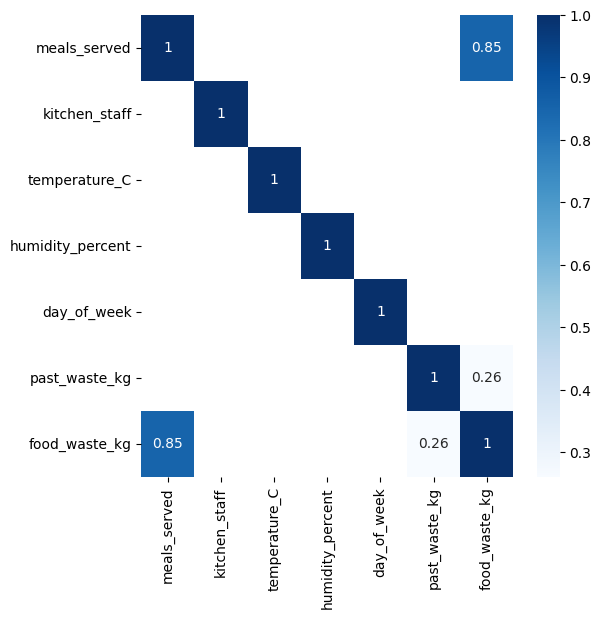

In [ ]:
# correlation matrix
corr=df.corr(numeric_only=True)
mask=(corr<0.25)&(corr>-0.25)

plt.figure(figsize=(6,6))
sns.heatmap(corr, annot=True, cmap='Blues',mask=mask)
plt.show()


In [ ]:
x=df.drop(columns="food_waste_kg")
y=df["food_waste_kg"]
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=42)

In [ ]:
x=df.drop(columns="food_waste_kg")
y=df["food_waste_kg"]
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=42)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
# Define column groups
scale_cols = ["meals_served", "kitchen_staff", "temperature_C", "humidity_percent", "past_waste_kg", "special_event"]
cat_cols = ["staff_experience", "waste_category"]  # Only these need encoding
preprocessor = ColumnTransformer([
    ("num_cols", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", RobustScaler())
    ]), scale_cols),  # `special_event` remains numeric here
   ("cat_cols", Pipeline([
       ("imputer", SimpleImputer(strategy="most_frequent")),
       ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))  # Encodes categorical features only
   ]), cat_cols)  # Only encode these
])
GBReg = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", GradientBoostingRegressor(max_depth=8, n_estimators=100, learning_rate=0.15, random_state=42))
])

In [ ]:
GBReg.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['meals_served',
                                                   'kitchen_staff',
                                                   'temperature_C',
                                                   'humidity_percent',
                                                   'past_waste_kg',
                                                   'special_event']),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['staff_experience',
                                                   'waste_category'])])),
                ('classifier',
                 GradientBoostingRegressor(learning_rate=0.15, max_depth=8,
                                           random_state=42))])

In [ ]:
#import pickle
#pickle.dump(GBReg,open("Gradient_boosting_reg.pkl","wb"))

In [ ]:
y_pred_gbr = GBReg.predict(x_test)
y_train_gbr = GBReg.predict(x_train)

mse_gbr=mean_squared_error(y_test, y_pred_gbr)
r2_gbr=r2_score(y_test, y_pred_gbr)
mae_gbr=mean_absolute_error(y_test, y_pred_gbr)

mse2_gbr=mean_squared_error(y_train, y_train_gbr)
r22_gbr=r2_score(y_train, y_train_gbr)
mae2_gbr=mean_absolute_error(y_train,y_train_gbr)

print("Mean squared error for Gradient boosting: ",mse_gbr)
print("R2 score for Gradient boosting: ",r2_gbr)
print("Mean absolute error for Gradient boosting: ",mae_gbr)
print("Mean squared error for Gradient boosting on train data: ",mse2_gbr)
print("R2 score for Gradient boosting on train data: ",r22_gbr)
print("Mean absolute error for Gradient boosting on train data: ",mae2_gbr)

Mean squared error for Gradient boosting:  98.75685474339652
R2 score for Gradient boosting:  0.8909689559404703
Mean absolute error for Gradient boosting:  5.108569266899859
Mean squared error for Gradient boosting on train data:  0.07112255071387971
R2 score for Gradient boosting on train data:  0.9999070569763674
Mean absolute error for Gradient boosting on train data:  0.1924041837640474


In [ ]:
df2=pd.read_csv("test.csv")
df3=pd.read_csv("test.csv")

In [ ]:
df2.drop(columns=["ID","date"],inplace=True)

In [ ]:
def lower_case_columns(df2, cols):
    df2[cols] = df2[cols].astype(str).apply(lambda x: x.str.lower())
    return df2
df2 = lower_case_columns(df2, ["waste_category"])

In [ ]:
df2["staff_experience"] = df2["staff_experience"].replace("intermediate", "Intermediate")

In [ ]:
cols=["special_event","staff_experience","waste_category"]
df2[cols]=df2[cols].astype("category")

In [ ]:
def handle_outlier(data,columns,method="IQR",threshold=1.5,strategy="replace"):
    for col in columns:
        if method=="IQR":
            Q1=data[col].quantile(0.25)
            Q3=data[col].quantile(0.75)
            IQR=Q3-Q1
            lower_bound=Q1-threshold*IQR
            upper_bound=Q3+threshold*IQR
        elif method=="Z-score":
            mean=data[col].mean()
            std=data[col].std()
            lower_bound=mean-threshold*std
            upper_bound=mean+threshold*std
        else:
            print("Invalid method")
        if strategy=="replace":
          #with median
            data[col]=np.clip(data[col],lower_bound,upper_bound)
        elif strategy=="remove":
            data=data[(data[col]>=lower_bound) & (data[col]<=upper_bound)]
        else:
            print("Invalid strategy. choose 'replace' or 'remove'")
    return data
COLUM_TO_Process=df2[["temperature_C"]]
df2=handle_outlier(df2,COLUM_TO_Process,method="IQR",threshold=.75,strategy="replace")

In [ ]:
X=df2

In [ ]:
y_pred5_Test = GBReg.predict(X)

In [ ]:
# Creating Submission file for Kaggle competition
# Author: [Badger Team]
# Date: 2025-02-17

submitted_data=y_pred5_Test           # Gradient Boosting regression

submission = pd.DataFrame({
    "ID": df3.iloc[:, 0],  # Extract first column [ID] is a DataFrame
    "food_waste_kg": submitted_data.flatten() if isinstance(submitted_data, np.ndarray) else submitted_data
})
submission.to_csv("submission.csv", index=False)

print("Submission file created successfully")

display(submission.head())

Submission file created successfully


,ID,food_waste_kg
0,0,28.591707
1,1,51.474693
2,4,52.886321
3,5,48.524697
4,6,44.333431


from matplotlib import pyplot as plt
_df_0['ID'].plot(kind='hist', bins=20, title='ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['food_waste_kg'].plot(kind='hist', bins=20, title='food_waste_kg')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='ID', y='food_waste_kg', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ID']
  ys = series['food_waste_kg']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('ID', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ID')
_ = plt.ylabel('food_waste_kg')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['ID']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'ID'}, axis=1)
              .sort_values('ID', ascending=True))
  xs = counted['ID']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('ID', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ID')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['ID'].plot(kind='line', figsize=(8, 4), title='ID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['food_waste_kg'].plot(kind='line', figsize=(8, 4), title='food_waste_kg')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['ID'].plot(kind='hist', bins=20, title='ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9['food_waste_kg'].plot(kind='hist', bins=20, title='food_waste_kg')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='index', y='ID', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='ID', y='food_waste_kg', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['food_waste_kg']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('food_waste_kg')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ID']
  ys = series['food_waste_kg']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('ID', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ID')
_ = plt.ylabel('food_waste_kg')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['ID']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'ID'}, axis=1)
              .sort_values('ID', ascending=True))
  xs = counted['ID']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('ID', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ID')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_16['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['ID'].plot(kind='line', figsize=(8, 4), title='ID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['food_waste_kg'].plot(kind='line', figsize=(8, 4), title='food_waste_kg')
plt.gca().spines[['top', 'right']].set_visible(False)